## Self-Driving Car - Vehicle Detection and Tracking

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import time

from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from vehicle_detection_helper import *

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
images_path = './data/input/mix_proj_udac/'

### The two classes - car and notcar
Sample car and notcar images

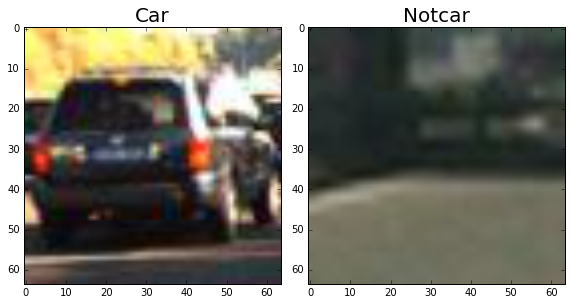

In [3]:
car = mpimg.imread(images_path + 'cars_jpg/519.jpg')
notcar = mpimg.imread(images_path + 'not-cars_jpg/image428.jpg')
fig = plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(car)
plt.title('Car', fontsize=20)
plt.subplot(132)
plt.imshow(notcar)
plt.title('Notcar', fontsize=20)
fig.tight_layout()

### Spatial Binning of Color

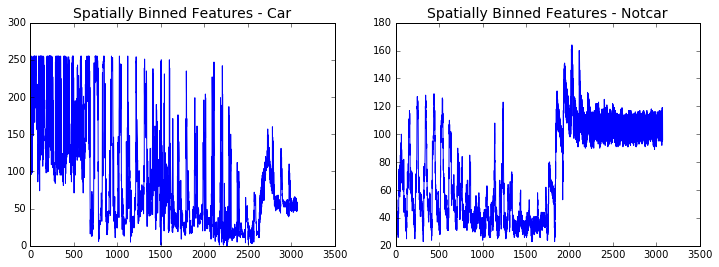

In [4]:
car_feature_vec = bin_spatial(car, size=(32, 32))

notcar_feature_vec = bin_spatial(notcar, size=(32,32))

fig = plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(car_feature_vec)
plt.title('Spatially Binned Features - Car', fontsize=14)
plt.subplot(122)
plt.plot(notcar_feature_vec)
plt.title('Spatially Binned Features - Notcar', fontsize=14)

### Histograms of Color

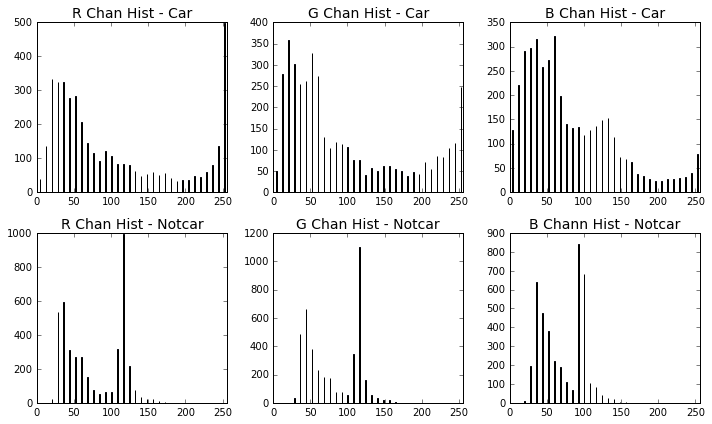

In [5]:
h1, h2, h3, bincen, feature_vec = color_hist(car, nbins=32, bins_range=(0, 256), vis=True)
nc1, nc2, nc3, ncbincen, ncfeature_vec = color_hist(notcar, nbins=32, bins_range=(0, 256), vis=True)

if h1 is not None:
    fig = plt.figure(figsize=(10,6))
    plt.subplot(231)
    plt.bar(bincen, h1[0])
    plt.xlim(0, 256)
    plt.title('R Chan Hist - Car', fontsize=14)
    plt.subplot(232)
    plt.bar(bincen, h2[0])
    plt.xlim(0, 256)
    plt.title('G Chan Hist - Car', fontsize=14)
    plt.subplot(233)
    plt.bar(bincen, h3[0])
    plt.xlim(0, 256)
    plt.title('B Chan Hist - Car', fontsize=14)
    plt.subplot(234)
    plt.bar(ncbincen, nc1[0])
    plt.xlim(0, 256)
    plt.title('R Chan Hist - Notcar', fontsize=14)
    plt.subplot(235)
    plt.bar(ncbincen, nc2[0])
    plt.xlim(0, 256)
    plt.title('G Chan Hist - Notcar', fontsize=14)
    plt.subplot(236)
    plt.bar(ncbincen, nc3[0])
    plt.xlim(0, 256)
    plt.title('B Chann Hist - Notcar', fontsize=14)
    fig.tight_layout()

### Histogram of Oriented Gradient (HOG) features

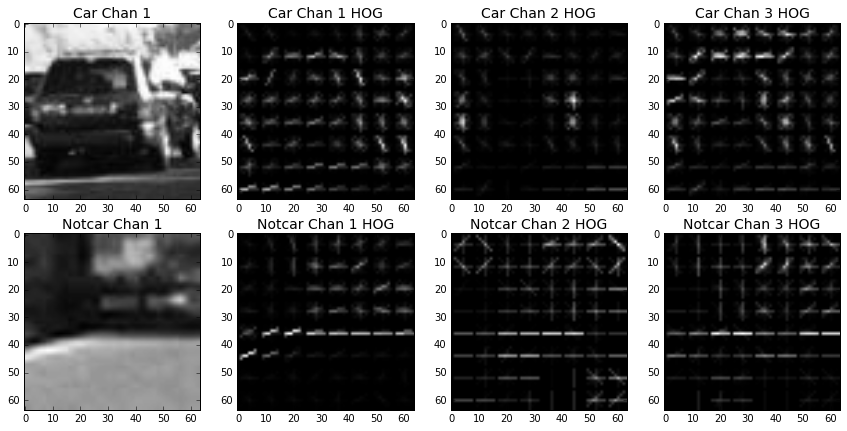

In [6]:
luv = convert_color(car, 'LUV')

features, hog_img1 = get_hog_features(luv[:,:,0], 16, 8, 2, 
                    vis=True, feature_vec=True)

features, hog_img2 = get_hog_features(luv[:,:,1], 16, 8, 2, 
                    vis=True, feature_vec=True)

features, hog_img3 = get_hog_features(luv[:,:,2], 16, 8, 2, 
                    vis=True, feature_vec=True)

notcar_luv = convert_color(notcar, 'LUV')
features, hog_notcar1 = get_hog_features(notcar_luv[:,:,0], 16, 8, 2, 
                    vis=True, feature_vec=True)

features, hog_notcar2 = get_hog_features(notcar_luv[:,:,1], 16, 8, 2, 
                    vis=True, feature_vec=True)

features, hog_notcar3 = get_hog_features(notcar_luv[:,:,2], 16, 8, 2, 
                    vis=True, feature_vec=True)

fig = plt.figure(figsize=(12,6))
# plt.subplot(<nrows><ncols><subplot_id>)
plt.subplot(241)
plt.imshow(cv2.cvtColor(car, cv2.COLOR_RGB2GRAY), cmap='gray')
plt.title('Car Chan 1', fontsize=14)
plt.subplot(242)
plt.imshow(hog_img1, cmap='gray')
plt.title('Car Chan 1 HOG', fontsize=14)
plt.subplot(243)
plt.imshow(hog_img2, cmap='gray')
plt.title('Car Chan 2 HOG', fontsize=14)
plt.subplot(244)
plt.imshow(hog_img3, cmap='gray')
plt.title('Car Chan 3 HOG', fontsize=14)
plt.subplot(245)
plt.imshow(cv2.cvtColor(notcar, cv2.COLOR_RGB2GRAY), cmap='gray')
plt.title('Notcar Chan 1', fontsize=14)
plt.subplot(246)
plt.imshow(hog_notcar1, cmap='gray')
plt.title('Notcar Chan 1 HOG', fontsize=14)
plt.subplot(247)
plt.imshow(hog_notcar2, cmap='gray')
plt.title('Notcar Chan 2 HOG', fontsize=14)
plt.subplot(248)
plt.imshow(hog_notcar3, cmap='gray')
plt.title('Notcar Chan 3 HOG', fontsize=14)
fig.tight_layout()

### Train a car/notcar classifier

In [7]:
# Read in cars and notcars
cars = glob.glob(images_path + 'cars_jpg/*.jpg')
notcars = glob.glob(images_path + 'not-cars_jpg/*.jpg')

# Reduce the sample size for rapid prototyping
# Comment out this portion to use entire data set
#sample_size = 5000
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

print('No. of cars:    {}'.format(len(cars)))
print('No. of notcars: {}'.format(len(notcars)))

color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, LAB
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [390, 675] # Min and max in y to search in slide_window()

No. of cars:    20837
No. of notcars: 21132


In [8]:
def scaled_X_y(cars,
               notcars,
               color_space,
               spatial_size,
               hist_bins,
               orient,
               pix_per_cell,
               cell_per_block,
               hog_channel,
               spatial_feat,
               hist_feat,
               hog_feat):
                   
    t = time.time()
    
    car_features = extract_features(cars,
                                    color_space=color_space,
                                    spatial_size=spatial_size,
                                    hist_bins=hist_bins,
                                    orient=orient,
                                    pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    hog_channel=hog_channel,
                                    spatial_feat=spatial_feat,
                                    hist_feat=hist_feat,
                                    hog_feat=hog_feat)

    notcar_features = extract_features(notcars,
                                       color_space=color_space,
                                       spatial_size=spatial_size,
                                       hist_bins=hist_bins,
                                       orient=orient,
                                       pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel,
                                       spatial_feat=spatial_feat,
                                       hist_feat=hist_feat,
                                       hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    t2 = time.time()
    print('Time taken to extract features: {}'.format(round(t2-t, 4)))
    
    return X_scaler, scaled_X, y


In [9]:
# Prep for training model
X_scaler, scaled_X, y = scaled_X_y(cars,
                                   notcars,
                                   color_space,
                                   spatial_size,
                                   hist_bins,
                                   orient,
                                   pix_per_cell,
                                   cell_per_block,
                                   hog_channel,
                                   spatial_feat,
                                   hist_feat,
                                   hog_feat)
                                   
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

print('Feature vector length:', len(X_train[0]))

# Save the X features scaler
joblib.dump(X_scaler, 'x_scaler.pkl')

Time taken to extract features: 263.762
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


['x_scaler.pkl']

In [10]:
# Train the Classifier
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Save the trained model
joblib.dump(svc, 'car-notcar-classifier.pkl')


51.87 Seconds to train SVC...
Test Accuracy of SVC =  0.9932


['car-notcar-classifier.pkl']

In [11]:
# Check the prediction time for a single sample
t = time.time()
print('Prediction on Test image ', svc.predict([X_test[64]]))
t2 = time.time()
print(round(t2-t,4), 'Seconds for a single prediction.')

Prediction on Test image  [ 0.]
0.0008 Seconds for a single prediction.


### Detect cars in test image using 'sliding window'

Execution time: 3.1553 seconds


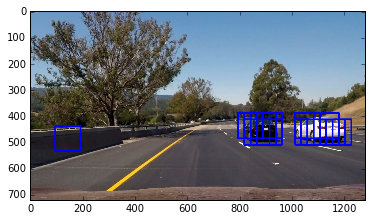

In [12]:
# Using sliding window, extracting hog features per window
test_img = mpimg.imread('./test_images/test6.jpg')
#test_img = mpimg.imread('./test_images/proj_vid_frame8.jpg')
draw_image = np.copy(test_img)

t = time.time()

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(test_img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(test_img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

t2 = time.time()
print('Execution time: {} seconds'.format(round(t2-t, 4)))

plt.imshow(window_img)

### Faster implementation using 'hog sub-sampling'

Extract features using hog sub-sampling on the entire image in single pass instead of calling hog on each sliding window patch. 

In [13]:
ystart = [420, 400, 390, 375]
ystop =  [720, 675, 580, 520]
xstart = [400, 450, 500, 575]
xstop =  [1280, 1280, 1280, 1280]
scales = [2.5, 2.0, 1.5, 1.25]
test_img = mpimg.imread('./test_images/test6.jpg')
#test_img = mpimg.imread('./test_images/proj_vid_frame8.jpg')

#### Visualize HOG subsampling patches

Saving ./visuals/hog-subsampling-patches.jpg


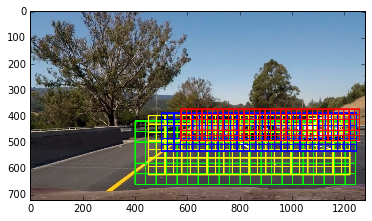

In [14]:
box_colors = [(0,255,0), (255,255,0), (0,0,255), (255,0,0)]


out_img, boxes = find_cars(test_img, ystart[0], ystop[0], xstart[0], xstop[0],
                  scales[0], svc, X_scaler, orient, pix_per_cell, cell_per_block,
                  spatial_size, hist_bins, hog_channel, 
                  color_space, True, box_colors[0])
out_img, boxes = find_cars(out_img, ystart[1], ystop[1], xstart[1], xstop[1],
                  scales[1], svc, X_scaler, orient, pix_per_cell, cell_per_block,
                  spatial_size, hist_bins, hog_channel, 
                  color_space, True, box_colors[1])
out_img, boxes = find_cars(out_img, ystart[2], ystop[2], xstart[2], xstop[2],
                  scales[2], svc, X_scaler, orient, pix_per_cell, cell_per_block,
                  spatial_size, hist_bins, hog_channel, 
                  color_space, True, box_colors[2])
out_img, boxes = find_cars(out_img, ystart[3], ystop[3], xstart[3], xstop[3],
                  scales[3], svc, X_scaler, orient, pix_per_cell, cell_per_block,
                  spatial_size, hist_bins, hog_channel, 
                  color_space, True, box_colors[3])

save_image('./visuals/hog-subsampling-patches.jpg', out_img, RGB=True)
plt.imshow(out_img)

Execution time: 0.5544 seconds


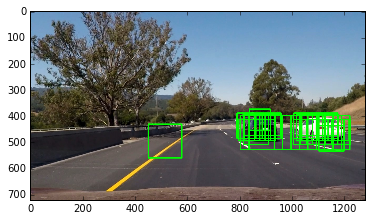

In [15]:
box_list = []
t = time.time()
for i, scale in enumerate(scales):
    boxes = find_cars(test_img, ystart[i], ystop[i], xstart[i], xstop[i], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel, color_space)
    box_list.extend(boxes)
    #print(len(box_list))
t2 = time.time()

out_img = draw_boxes(test_img, box_list)
print("Execution time: {} seconds".format(round(t2-t, 4)))

plt.imshow(out_img)

### Aggregate positive multiple-detection windows and eliminate false positives using heat maps

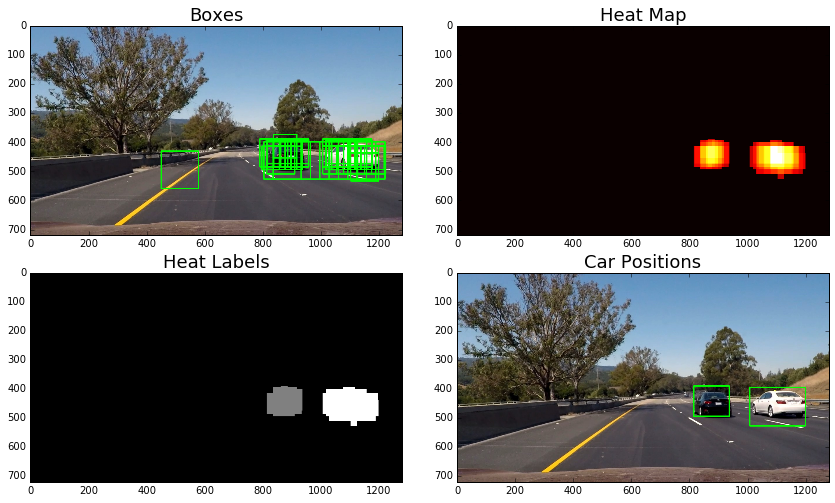

In [16]:
image = test_img
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 4)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(12,7))

plt.subplot(221)
plt.imshow(out_img)
plt.title('Boxes', fontsize=18)
plt.subplot(222)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map', fontsize=18)
plt.subplot(223)
plt.imshow(labels[0], cmap='gray')
plt.title('Heat Labels', fontsize=18)
plt.subplot(224)
plt.imshow(draw_img)
plt.title('Car Positions', fontsize=18)
fig.tight_layout()

### Create the car detection/tracking pipeline

In [17]:
def look_for_cars(image,
                  svc,
                  X_scaler,
                  orient=9,
                  pix_per_cell=8,
                  cell_per_block=2,
                  spatial_size=(32,32),
                  hist_bins=32, 
                  ystart=[420, 400, 390, 375],
                  ystop=[720, 675, 580, 520],
                  xstart=[400, 450, 575, 500],
                  xstop=[1280, 1280, 1280, 1280],
                  hog_channel='ALL',
                  color_space='LUV'):

    # Detect car features
    scales = [2.5, 2.0, 1.5, 1.25]
    box_list = []

    for i, scale in enumerate(scales):
        boxes = find_cars(image, ystart[i], ystop[i], xstart[i], xstop[i], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel, color_space)
        box_list.extend(boxes)
        
    
    # Consolidate boxes and eliminate false positives
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    heat = apply_threshold(heat, 4)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

#### Test the pipeline

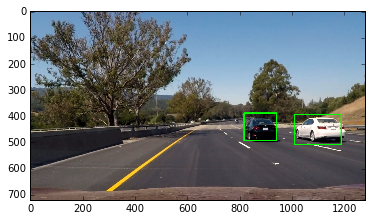

In [18]:
plt.imshow(look_for_cars(test_img, svc, X_scaler))

In [19]:
clf = None
x_scaler = None

def process_image(image):
    global clf
    global x_scaler
    
    if clf is None:
        clf = joblib.load('car-notcar-classifier.pkl')
        
    if x_scaler is None:
        x_scaler = joblib.load('x_scaler.pkl')
        
    orient         = 9
    pix_per_cell   = 8
    cell_per_block = 2
    spatial_size   = (32, 32)
    hist_bins      = 32
    hog_channel    = 'ALL'
    color_space    = 'LUV'
    ystart         = [420, 400, 390, 375]
    ystop          = [720, 675, 580, 520]
    xstart         = [400, 450, 575, 500]
    xstop          = [1280, 1280, 1280, 1280]
    
    return look_for_cars(image,
                         clf,
                         x_scaler,
                         orient,
                         pix_per_cell,
                         cell_per_block,
                         spatial_size,
                         hist_bins,
                         ystart,
                         ystop,
                         xstart,
                         xstop,
                         hog_channel,
                         color_space)

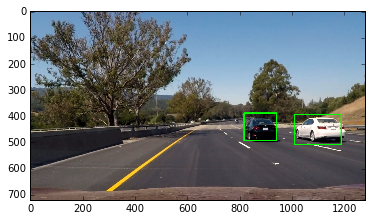

In [20]:
plt.imshow(process_image(test_img))

In [21]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
from IPython.display import HTML

In [22]:
project_output = './output_videos/project_output.mp4'
clip1 = VideoFileClip("./test_videos/project_video.mp4")
proj_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time proj_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_output.mp4
[MoviePy] Writing video ./output_videos/project_output.mp4


100%|█████████▉| 1260/1261 [13:32<00:00,  1.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_output.mp4 

CPU times: user 31min 16s, sys: 10.6 s, total: 31min 27s
Wall time: 13min 34s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./output_videos/project_output.mp4'))